## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-07-22 00:20:05.202 | INFO     |  Running on cpu


In [3]:
task = "BlockCabinetAllMoveTo"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-07-22 00:20:09.383 | INFO     |  Loading dataset(s): 
2025-07-22 00:20:09.384 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockCabinetAllMoveTo/demos/metadata.json
2025-07-22 00:20:09.385 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6, 255]
2025-07-22 00:20:09.385 | INFO     |    Extracted tsdf object labels []
2025-07-22 00:20:09.385 | INFO     |    Done! Data contains 3 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([121, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([121]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([121, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([121, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([121, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([121, 3, 256, 256]), device=cpu, dt

In [6]:
tag = "release"

tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,  # Use rotation aswell?
    add_gripper_action=True,
    heal_time_variance=False,
    reg_shrink=1e-2,  # 1e-2 is 0.01
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    em_steps=50,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.75,
    use_bic=False,  # Does prune segmentation
    drop_redundant_frames=True,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.0005,
    components_prop_to_len=True,
    min_end_distance=2,
    min_len=5
)

cascade_config = CascadeConfig()

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-07-22 00:20:12.341 | INFO     |  Fitting AutoTPGMM
2025-07-22 00:20:12.342 | INFO     |  Performing fitting actions: [INIT]
2025-07-22 00:20:12.342 | INFO     |  Segmenting trajectories


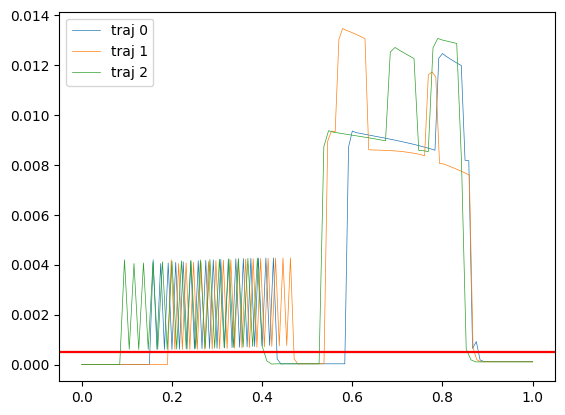

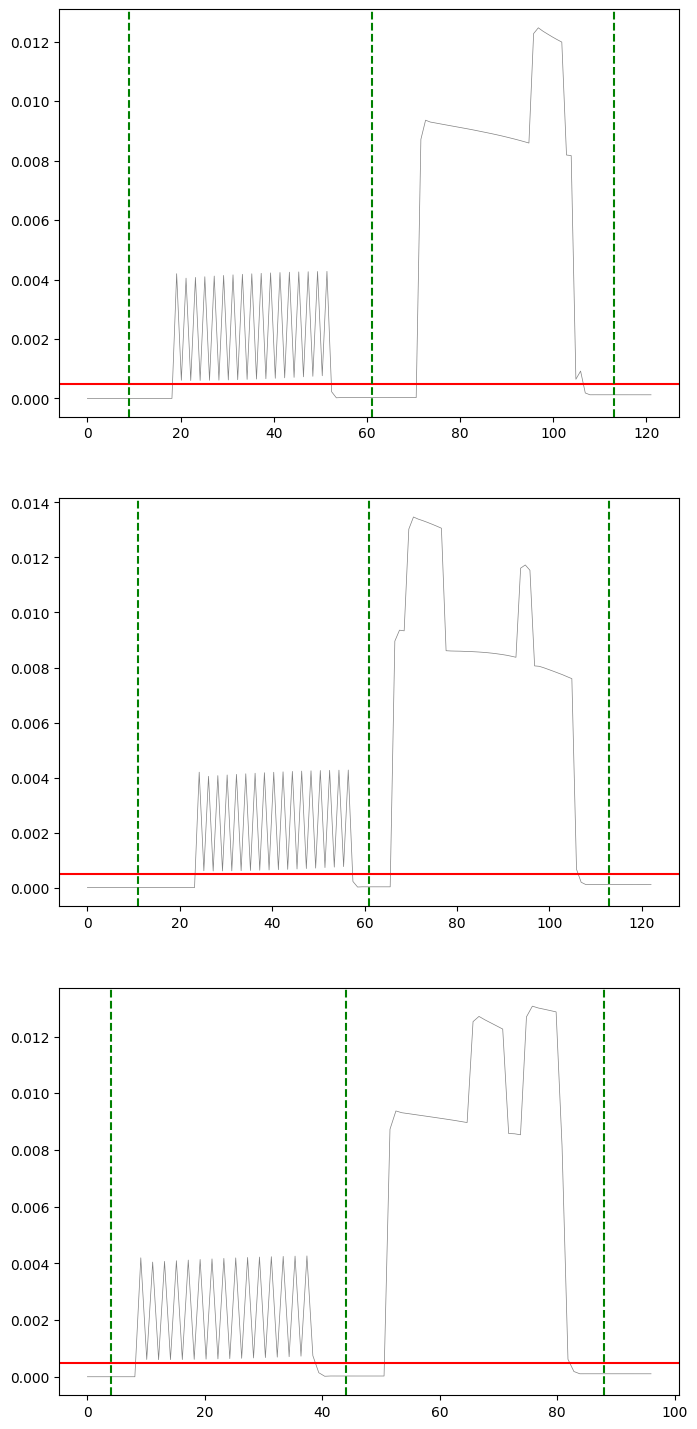

2025-07-22 00:20:12.912 | INFO     |  Creating segement of demos.
2025-07-22 00:20:12.916 | INFO     |  Subsampling to length 17 using strategy mean-length.
2025-07-22 00:20:12.916 | INFO     |  Creating segement of demos.
2025-07-22 00:20:12.921 | INFO     |  Subsampling to length 56 using strategy mean-length.
2025-07-22 00:20:12.922 | INFO     |  Creating segement of demos.
2025-07-22 00:20:12.926 | INFO     |  Subsampling to length 58 using strategy mean-length.
2025-07-22 00:20:12.926 | INFO     |  Creating segement of demos.
2025-07-22 00:20:12.931 | INFO     |  ... created 4 segments
2025-07-22 00:20:12.931 | INFO     |    Fitting candidate frame 1/10
2025-07-22 00:20:12.931 | INFO     |    Creating partial frame view of demos.
2025-07-22 00:20:12.935 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-07-22 00:20:12.935 | INFO     |    Changing number of components to 1
2025-07-22 00:20:12.935 | INFO     |    Model init ...


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:12.980 | INFO     |    Fitting candidate frame 2/10
2025-07-22 00:20:12.980 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:13.033 | INFO     |    Fitting candidate frame 3/10
2025-07-22 00:20:13.034 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:13.091 | INFO     |    Fitting candidate frame 4/10
2025-07-22 00:20:13.091 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:13.206 | INFO     |    Fitting candidate frame 5/10
2025-07-22 00:20:13.206 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:13.310 | INFO     |    Fitting candidate frame 6/10
2025-07-22 00:20:13.312 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:13.406 | INFO     |    Fitting candidate frame 7/10
2025-07-22 00:20:13.407 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:13.472 | INFO     |    Fitting candidate frame 8/10
2025-07-22 00:20:13.472 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:13.544 | INFO     |    Fitting candidate frame 9/10
2025-07-22 00:20:13.544 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:13.640 | INFO     |    Fitting candidate frame 10/10
2025-07-22 00:20:13.640 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:13.788 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-07-22 00:20:13.790 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-07-22 00:20:13.790 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-07-22 00:20:13.790 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-07-22 00:20:13.790 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-07-22 00:20:13.790 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-07-22 00:20:13.790 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-07-22 00:20:13.790 | INFO     |  obj006     score (rel):     -0 (0.000)
2025-07-22 00:20:13.790 | INFO     |  obj007     score (rel):     -0 (0.000)
2025-07-22 00:20:13.791 | INFO     |  obj008     score (rel):     -0 (0.000)
2025-07-22 00:20:13.791 | INFO     |  Dropping redundant frames [1 2 3 4 5 6].
2025-07-22 00:20:13.791 | INFO     |  Creating partial frame view of demos.
2025-07-22 00:20:13.796 | INFO     |    Fitting candidate frame 1/10
2025-0

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:13.975 | INFO     |    Fitting candidate frame 2/10
2025-07-22 00:20:13.976 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:14.126 | INFO     |    Fitting candidate frame 3/10
2025-07-22 00:20:14.126 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:14.316 | INFO     |    Fitting candidate frame 4/10
2025-07-22 00:20:14.316 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:14.467 | INFO     |    Fitting candidate frame 5/10
2025-07-22 00:20:14.467 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:14.617 | INFO     |    Fitting candidate frame 6/10
2025-07-22 00:20:14.617 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:14.881 | INFO     |    Fitting candidate frame 7/10
2025-07-22 00:20:14.881 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:15.057 | INFO     |    Fitting candidate frame 8/10
2025-07-22 00:20:15.057 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:15.213 | INFO     |    Fitting candidate frame 9/10
2025-07-22 00:20:15.214 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:15.427 | INFO     |    Fitting candidate frame 10/10
2025-07-22 00:20:15.427 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:15.755 | INFO     |  Creating partial frame view of demos.
2025-07-22 00:20:15.757 | INFO     |    Fitting candidate frame 1/10
2025-07-22 00:20:15.757 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:15.934 | INFO     |    Fitting candidate frame 2/10
2025-07-22 00:20:15.935 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:16.161 | INFO     |    Fitting candidate frame 3/10
2025-07-22 00:20:16.163 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:16.327 | INFO     |    Fitting candidate frame 4/10
2025-07-22 00:20:16.327 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:16.478 | INFO     |    Fitting candidate frame 5/10
2025-07-22 00:20:16.479 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:16.624 | INFO     |    Fitting candidate frame 6/10
2025-07-22 00:20:16.624 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:16.823 | INFO     |    Fitting candidate frame 7/10
2025-07-22 00:20:16.823 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:16.974 | INFO     |    Fitting candidate frame 8/10
2025-07-22 00:20:16.974 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:17.145 | INFO     |    Fitting candidate frame 9/10
2025-07-22 00:20:17.145 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:17.326 | INFO     |    Fitting candidate frame 10/10
2025-07-22 00:20:17.326 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:20:17.655 | INFO     |  obj006     score (rel):     -0 (0.002)
2025-07-22 00:20:17.657 | INFO     |  Creating partial frame view of demos.
2025-07-22 00:20:17.658 | INFO     |    Fitting candidate frame 1/10
2025-07-22 00:20:17.658 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:17.747 | INFO     |    Fitting candidate frame 2/10
2025-07-22 00:20:17.748 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:17.890 | INFO     |    Fitting candidate frame 3/10
2025-07-22 00:20:17.891 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:17.952 | INFO     |    Fitting candidate frame 4/10
2025-07-22 00:20:17.953 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:18.004 | INFO     |    Fitting candidate frame 5/10
2025-07-22 00:20:18.005 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:18.057 | INFO     |    Fitting candidate frame 6/10
2025-07-22 00:20:18.057 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:18.109 | INFO     |    Fitting candidate frame 7/10
2025-07-22 00:20:18.109 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:18.164 | INFO     |    Fitting candidate frame 8/10
2025-07-22 00:20:18.165 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:18.236 | INFO     |    Fitting candidate frame 9/10
2025-07-22 00:20:18.237 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:18.321 | INFO     |    Fitting candidate frame 10/10
2025-07-22 00:20:18.322 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 00:20:18.463 | INFO     |  Creating partial frame view of demos.
2025-07-22 00:20:18.469 | INFO     |  Segmented trajs into 4 segments
2025-07-22 00:20:18.496 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857   
Segment 1 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857   
Segment 2 -0.142858 -0.142856 -0.142856 -0.142856 -0.142856 -0.142856   
Segment 3 -0.142810 -0.142810 -0.142810 -0.142810 -0.142810 -0.142810   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142857 -7.571261e-07 -9.313727e-08 -1.980080e-08  
Segment 1 -0.142857 -4.107261e-06 -5.312648e-07 -1.077328e-07  
Segment 2 -0.142856 -2.808804e-04 -4.153391e-05 -7.920604e-06  
Segment 3 -0.142810 -2.794721e-04 -4.128178e-05 -7.869668e-06  
2025-07-22 00:20:18.511 | INFO     |  Frame score (rel):
            ee_init    obj000    obj001    obj002    o

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[3.25e+13, 3.25e+13, 2.65e+13, 1.77e+13, 9.63e+12, 4.28e+12,
          1.55e+12, 4.60e+11, 1.11e+11, 2.20e+10, 3.54e+09, 4.66e+08,
          5.01e+07, 4.40e+06, 3.15e+05, 1.84e+04, 8.81e+02, 3.25e+13,
          3.25e+13, 2.65e+13, 1.77e+13, 9.63e+12, 4.28e+12, 1.55e+12,
          4.60e+11, 1.11e+11, 2.20e+10, 3.54e+09, 4.66e+08, 5.01e+07,
          4.40e+06, 3.15e+05, 1.84e+04, 8.81e+02, 3.25e+13, 3.25e+13,
          2.65e+13, 1.77e+13, 9.63e+12, 4.28e+12, 1.55e+12, 4.60e+11,
          1.11e+11, 2.20e+10, 3.54e+09, 4.66e+08, 5.01e+07, 4.40e+06,
          3.15e+05, 1.84e+04, 8.81e+02],
         [1.08e+13, 1.80e+13, 2.51e+13, 2.98e+13, 2.98e+13, 2.51e+13,
          1.80e+13, 1.08e+13, 5.52e+12, 2.37e+12, 8.63e+11, 2.65e+11,
          6.89e+10, 1.51e+10, 2.80e+09, 4.38e+08, 5.79e+07, 1.08e+13,
          1.80e+13, 2.51e+13, 2.98e+13, 2.98e+13, 2.51e+13, 1.80e+13,
          1.08e+13, 5.52e+12, 2.37e+12, 8.63e+11, 2.65e+11, 6.89e+10,
          1.51e+10, 2.80e+09, 4.38e+08, 5.79e+07,

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-07-22 00:20:19.124 | INFO     |  Did not specify time_based, deciding automatically.


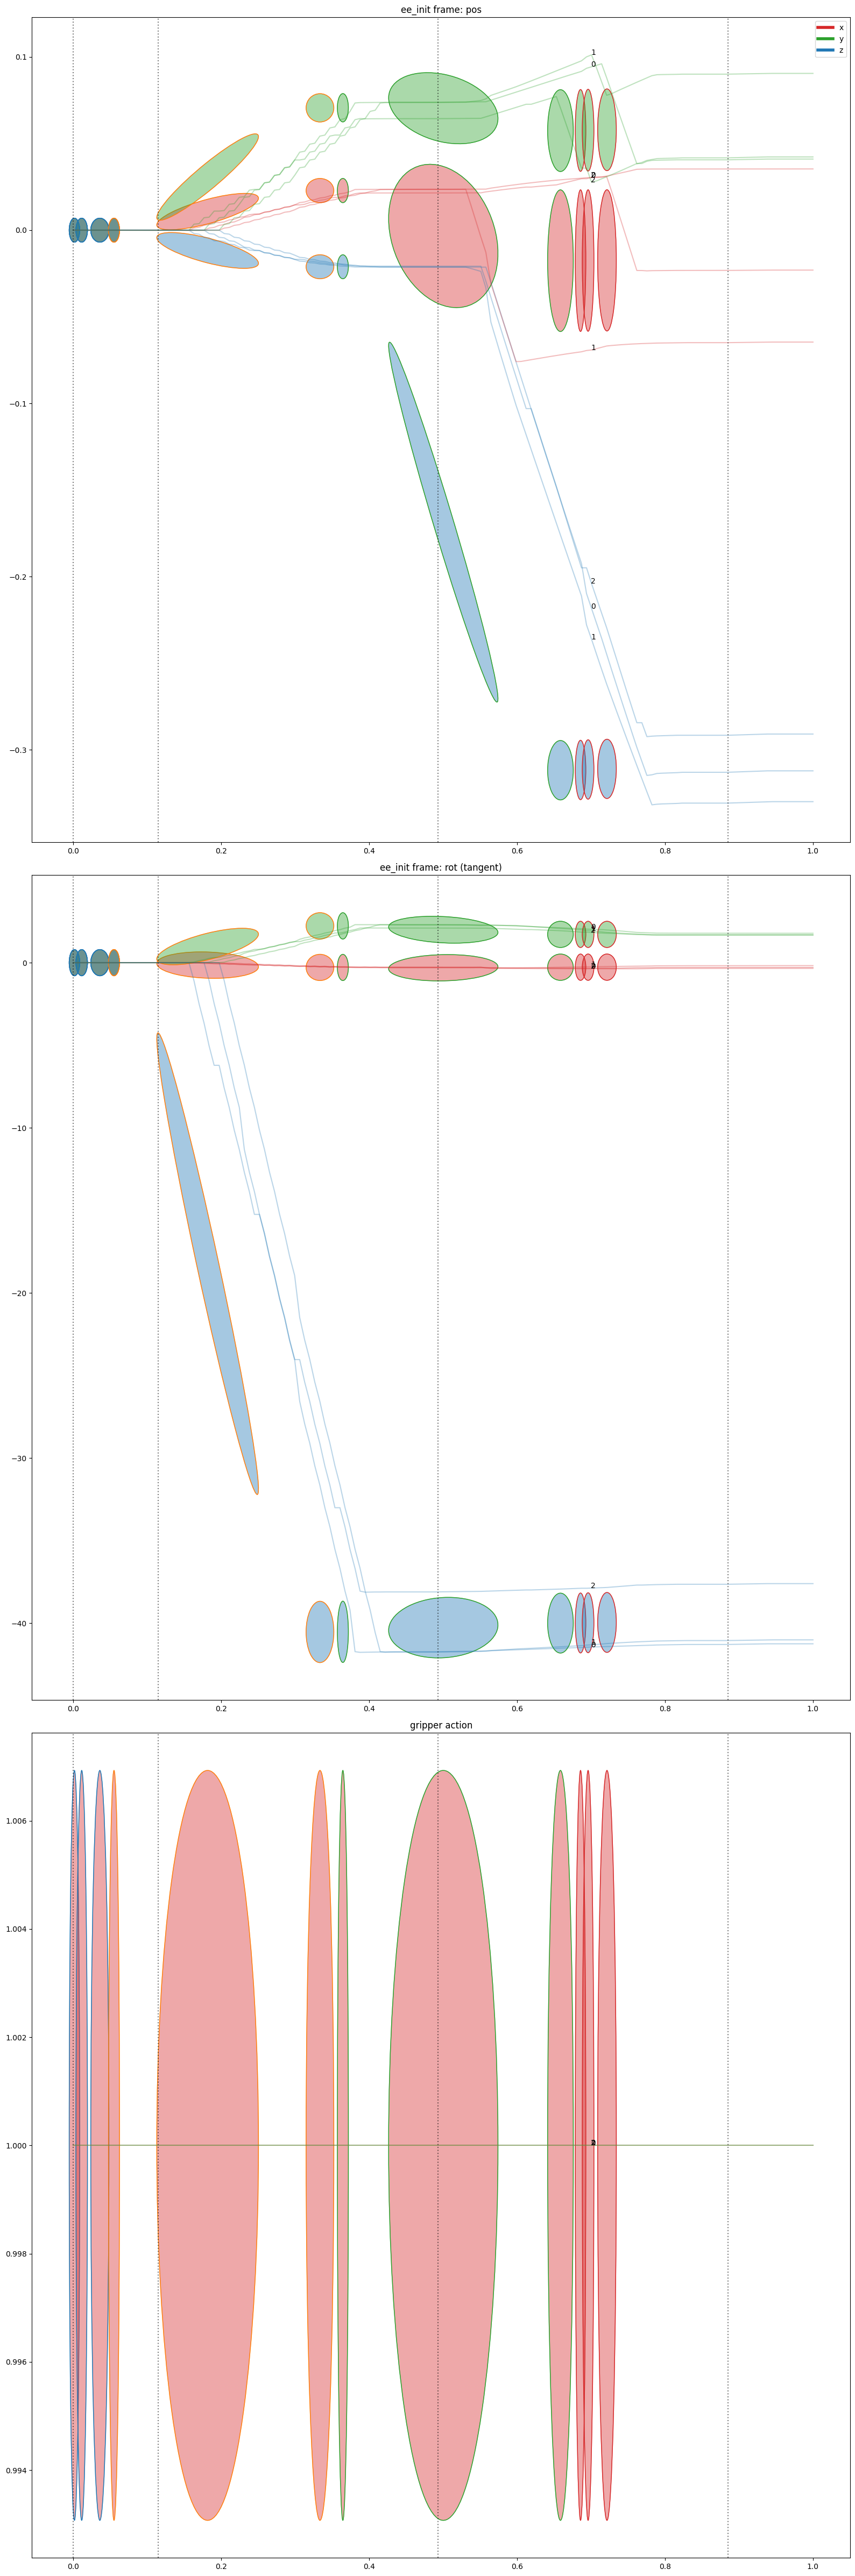

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-07-22 00:20:21.366 | INFO     |  Fitting AutoTPGMM
2025-07-22 00:20:21.367 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-22 00:20:21.379 | INFO     |  HMM EM ...
2025-07-22 00:20:21.381 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-07-22 00:20:21.405 | INFO     |  HMM init priors not defined, initializing to uniform
2025-07-22 00:20:21.545 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+00, 9.97e-01, 9.64e-01, 7.75e-01, 3.63e-01, 6.58e-02,
          3.36e-03, 3.93e-05, 8.99e-08, 3.48e-11, 2.00e-15, 1.49e-20,
          1.25e-26, 1.04e-33, 7.48e-42, 4.06e-51, 7.30e-57, 1.00e+00,
          9.97e-01, 9.64e-01, 7.75e-01, 3.63e-01, 6.58e-02, 3.36e-03,
          3.93e-05, 8.99e-08, 3.48e-11, 2.00e-15, 1.49e-20, 1.25e-26,
          1.04e-33, 7.48e-42, 4.06e-51, 7.30e-57, 1.00e+00, 9.97e-01,
          9.64e-01, 7.75e-01, 3.63e-01, 6.58e-02, 3.36e-03, 3.93e-05,
          8.99e-08, 3.48e-11, 2.00e-15, 1.49e-20, 1.25e-26, 1.04e-33,
          7.48e-42, 4.06e-51, 7.30e-57],
         [6.31e-14, 2.51e-03, 3.31e-02, 1.89e-01, 4.12e-01, 2.98e-01,
          6.24e-02, 3.32e-03, 3.92e-05, 8.98e-08, 3.49e-11, 2.00e-15,
          1.50e-20, 1.31e-26, 1.42e-33, 3.80e-41, 6.29e-49, 6.31e-14,
          2.51e-03, 3.31e-02, 1.89e-01, 4.12e-01, 2.98e-01, 6.24e-02,
          3.32e-03, 3.92e-05, 8.98e-08, 3.49e-11, 2.00e-15, 1.50e-20,
          1.31e-26, 1.42e-33, 3.80e-41, 6.29e-49,

2025-07-22 00:20:23.562 | INFO     |  Did not specify time_based, deciding automatically.


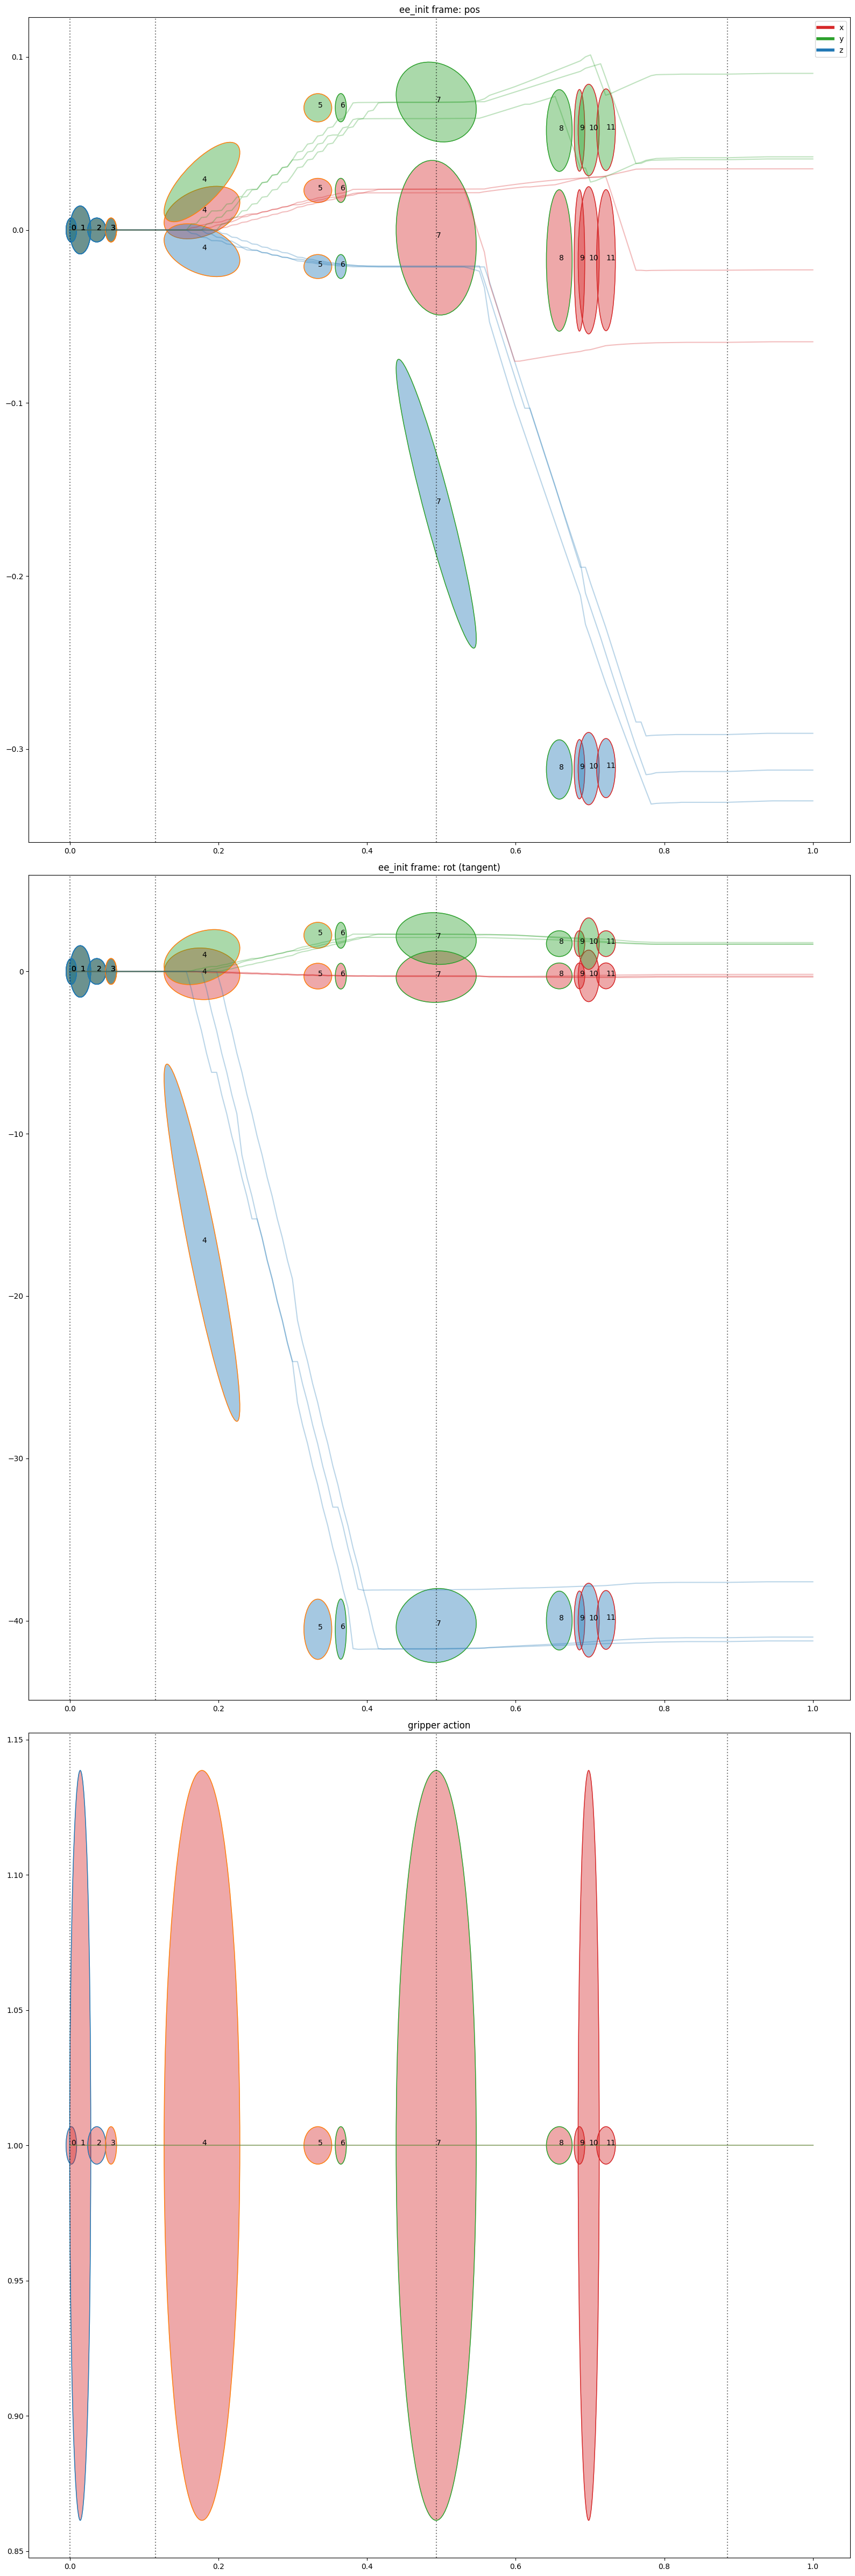

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

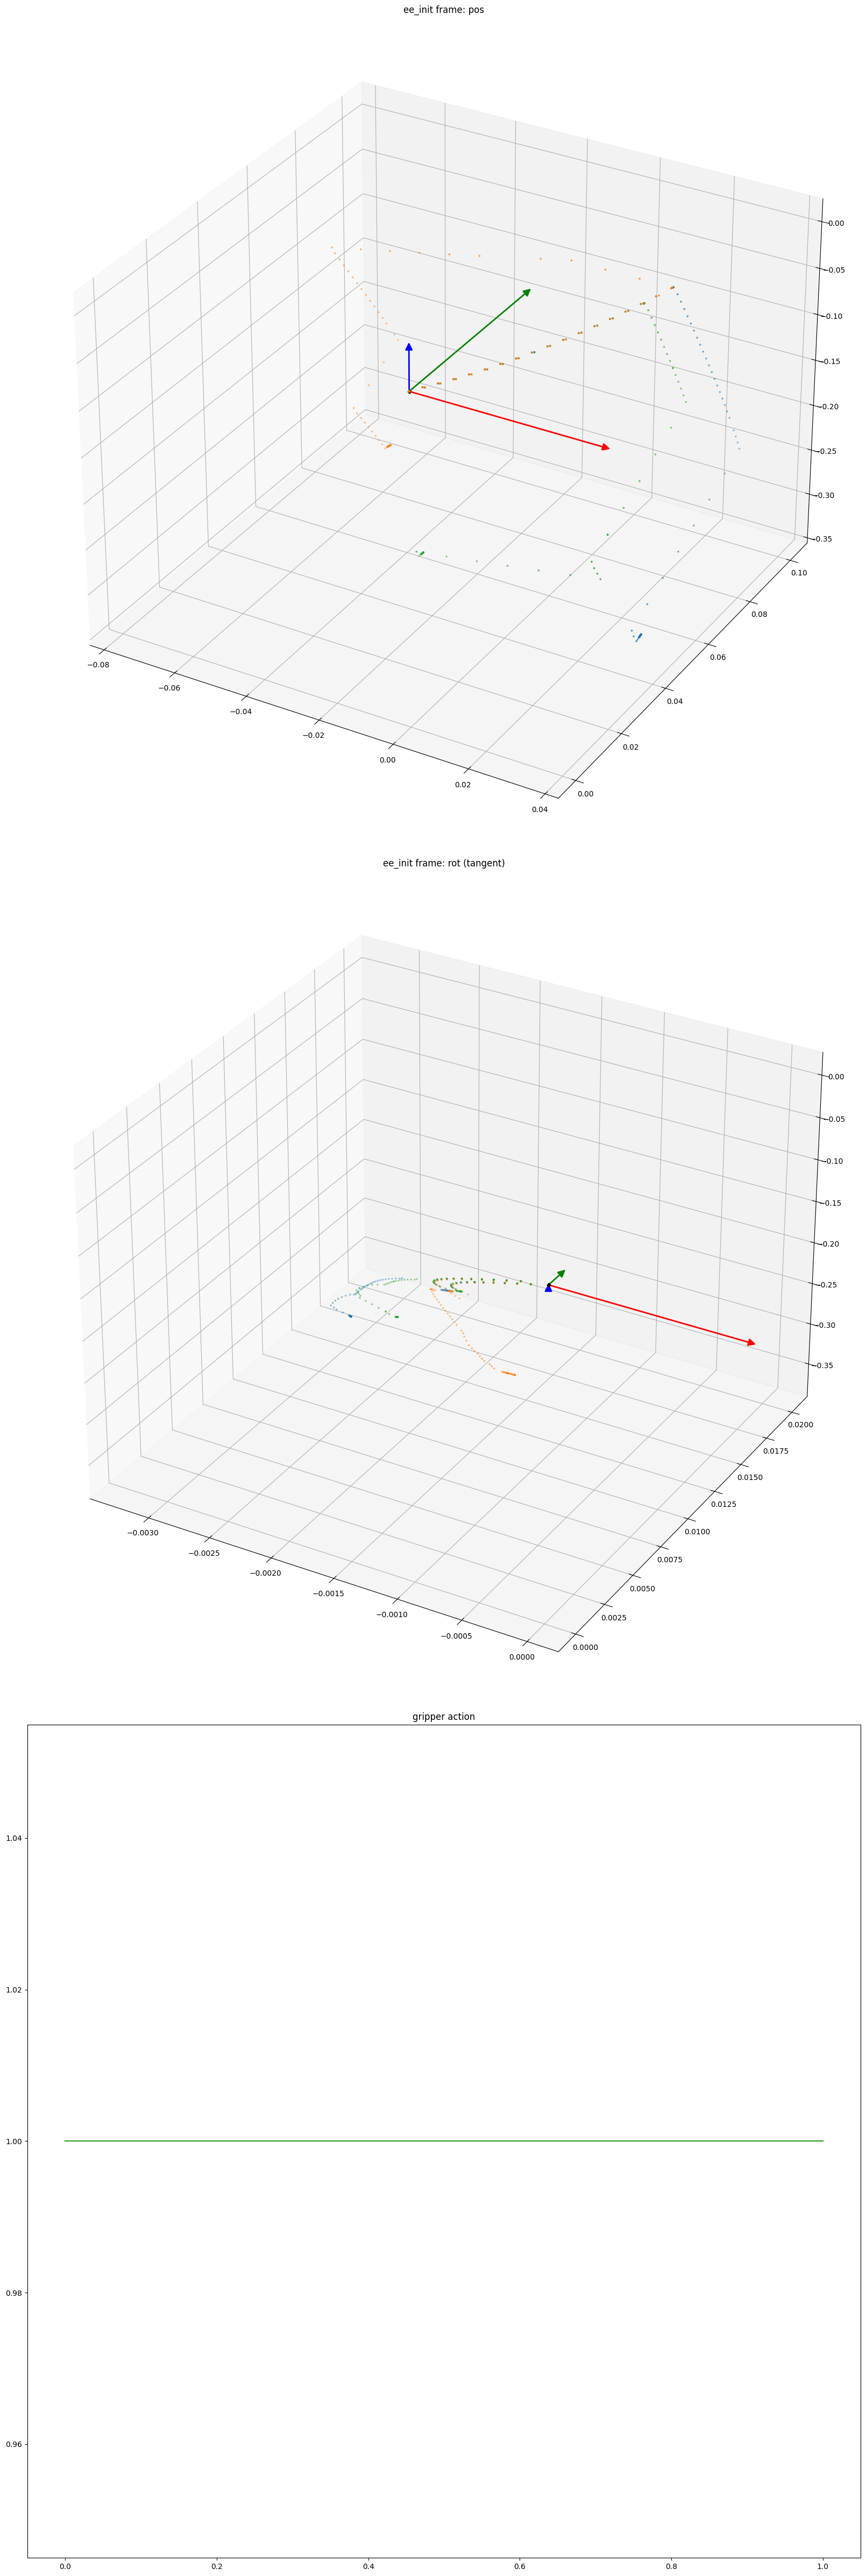

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

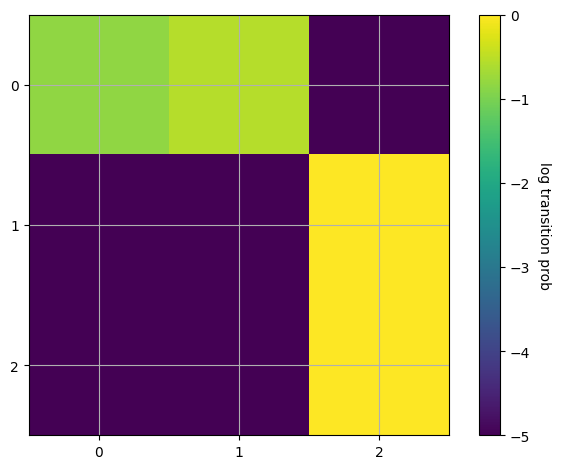

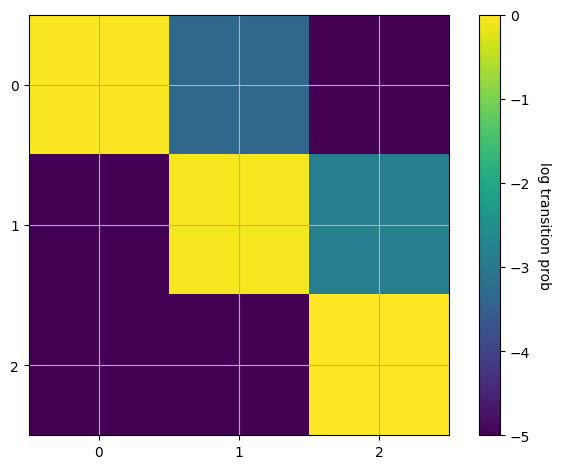

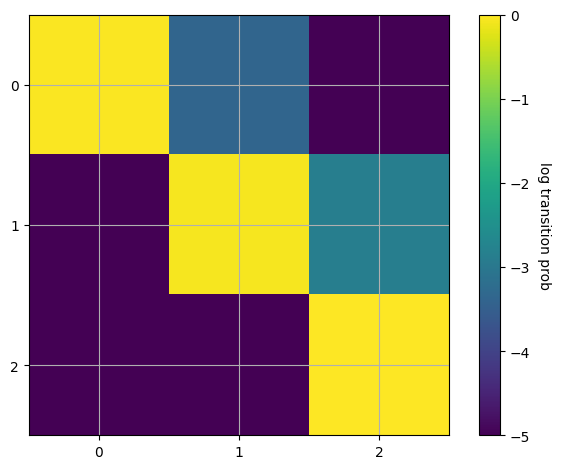

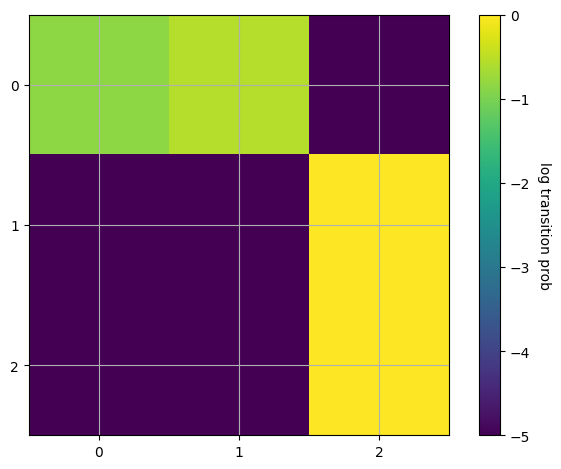

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-07-22 00:20:28.484 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-07-22 00:20:28.659 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-07-22 00:21:15.384 | INFO     |  Caculated segment transition probabilities: (array([[0.03]]), array([[4.67e-05]]), array([[0.]]))
2025-07-22 00:21:15.384 | WARNING  |  At least one segment transition prob below 5%. Can lead to problems.Consider increasing the diag reg.
2025-07-22 00:21:15.384 | INFO     |  Creating partial frame view of demos.
2025-07-22 00:21:15.387 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/3 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:21:15.434 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/3 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:21:15.480 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/3 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:21:15.533 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/3 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 00:21:15.589 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/3 [00:00<?, ?it/s]

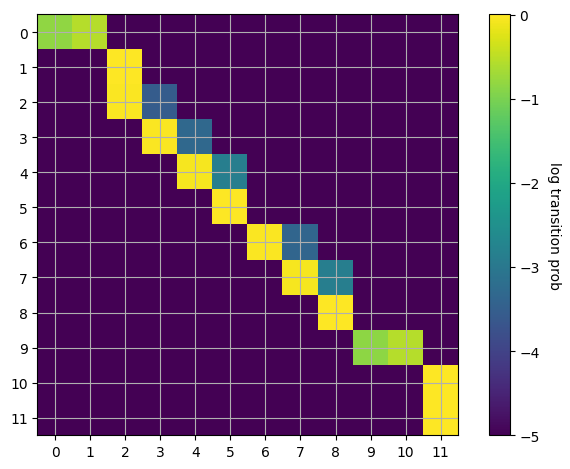

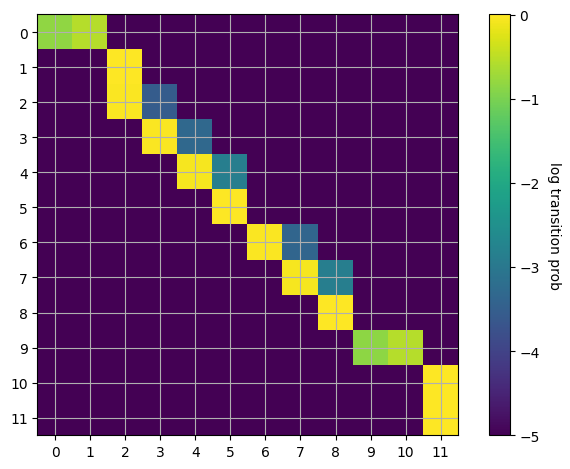

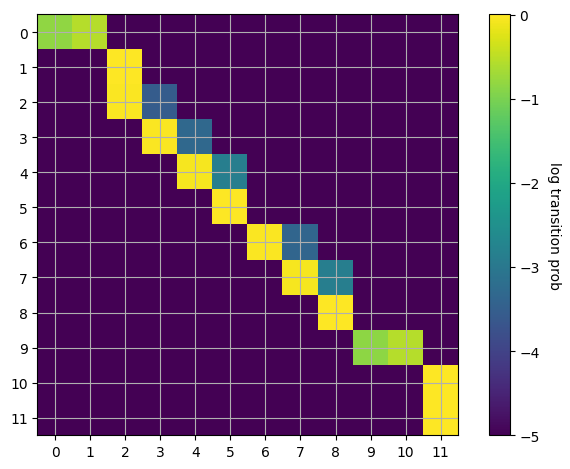

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-07-22 00:21:21.950 | INFO     |  Taking frame origins from demos.


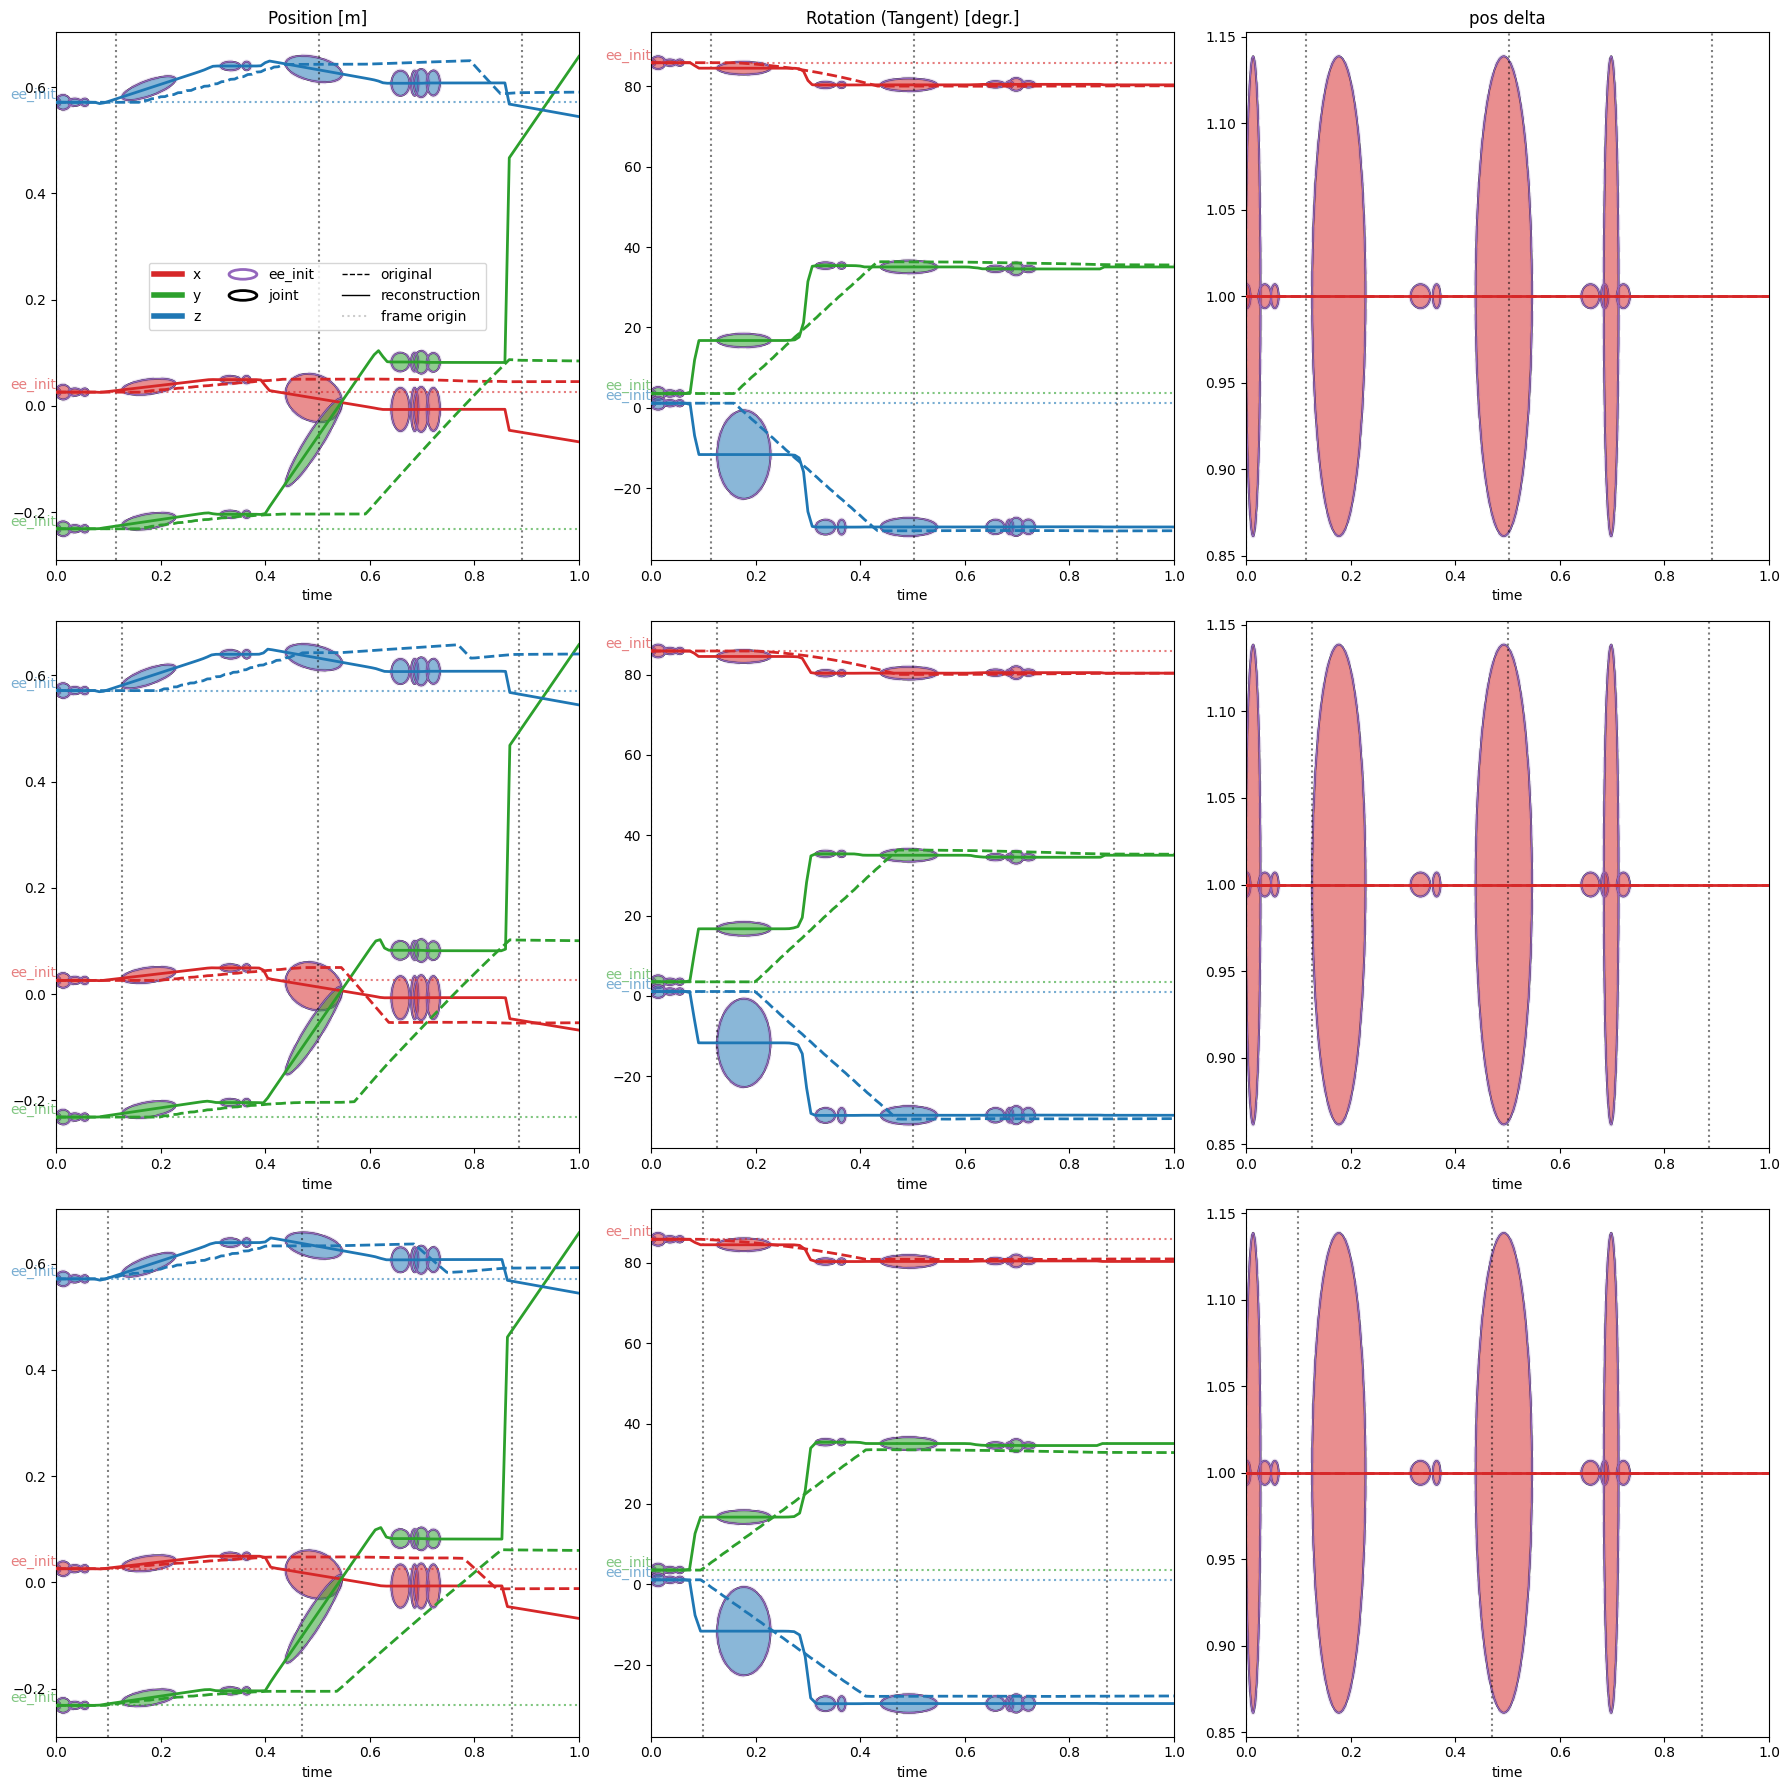

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2025-07-22 00:21:29.340 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


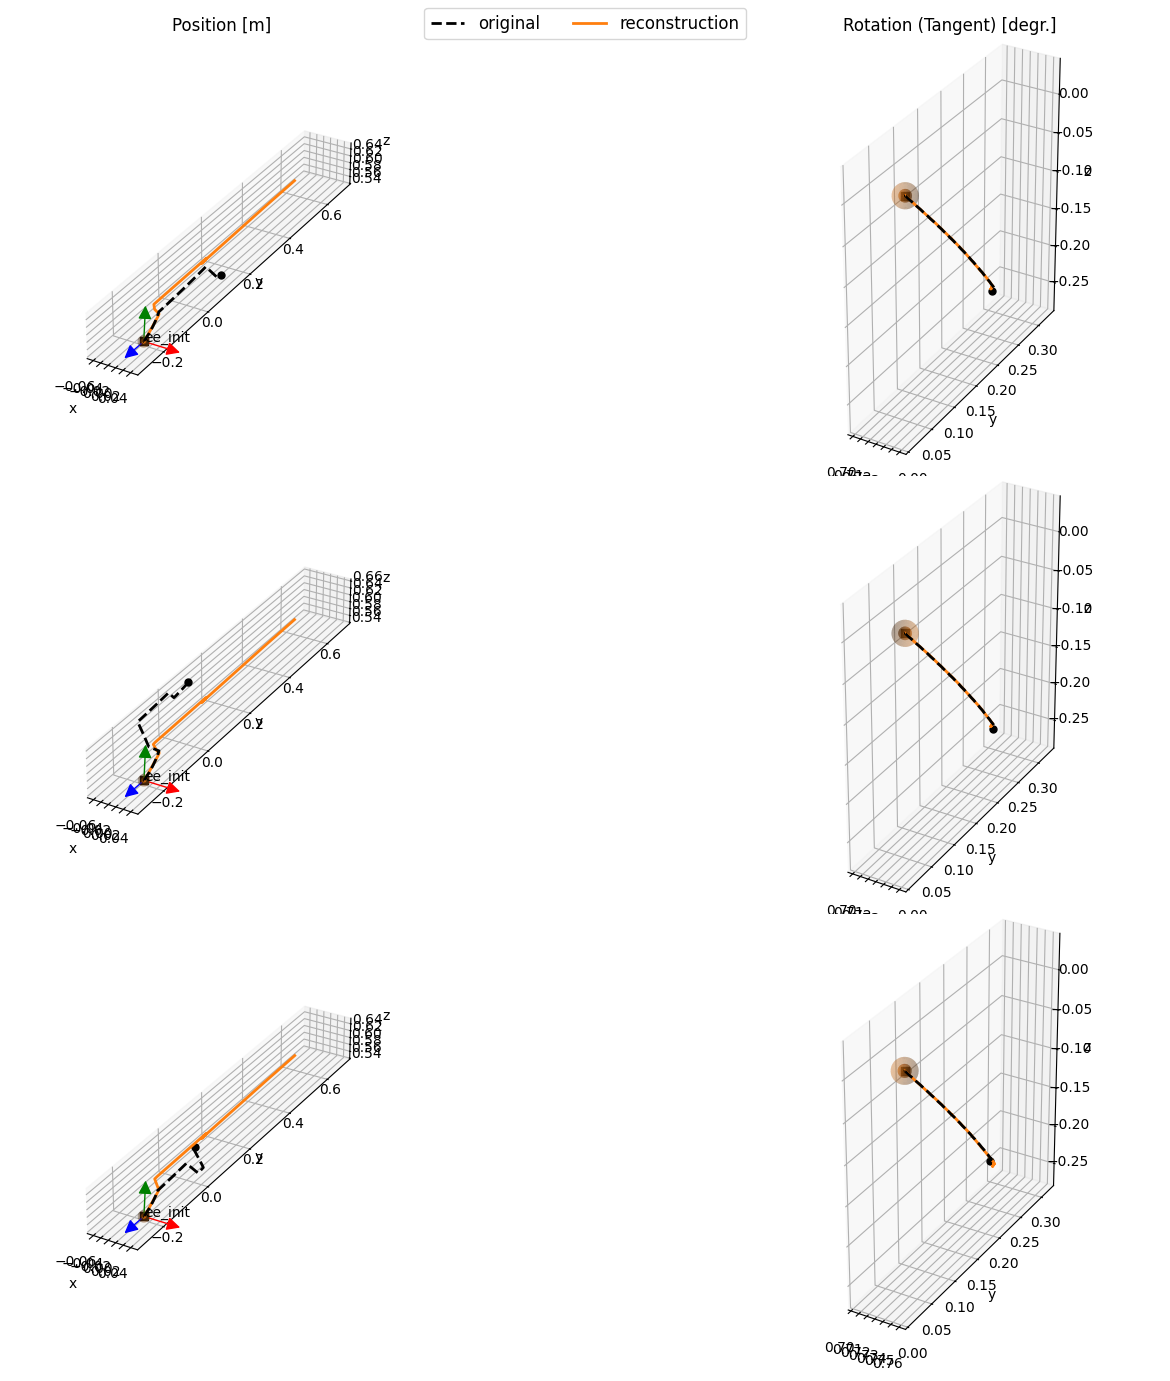

In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
